# Patent Embedding for Technology Sectoral Disruption

In this notebook, I will walk through the process of deriving patent bundle $P_{j,t}$ using various data source and the implementation of Bert for Patent model developed by Google. For more context and background, please refer to [this document](https://www.dropbox.com/scl/fi/lqtrk24w9htan752ryvhn/Meeting-Notes.paper?rlkey=ww1atds6uivl9ov6legrn7gy5&dl=0).

To run this notebook succesfully, you should create a new virtual environment and install all packages in [env.yml](https://www.dropbox.com/scl/fi/dp4a1qvgq34zy12dynr50/env.yml?rlkey=fs1u3cuzscgr1g5agi25qrm0c&st=80mwejor&dl=0). Run the command below in the terminal to set up a virtual environment with [conda](https://www.anaconda.com/docs/getting-started/miniconda/install).

```bash
# make sure to download and save env.yml on your local machine
conda env create -f <complete/path/to/env.yml>
```

Once it's setup, run `conda activate patent` to access the environment.

**❗ Make sure to adjust all file paths accordingly!!**

## Derive $P_{j,t}$
The pipeline for constructing $P_{j,t}$ is as follow:
1. Query patent embedding from Google BigQuery
2. Merge patent embedding with KPSS and SIC data
3. Group and average patent embedding by sector and time

For optimal performance, this section should be run on a machine with multiple CPUs and sufficient memory.

#### 1. Query patent embedding from Google BigQuery
To query from Google BigQuery, you must first create and save a service key from Google Console by following [these steps](https://cloud.google.com/iam/docs/keys-create-delete#creating). The key should be saved as a json file.

In [2]:
# srun --tasks-per-node=1 --gres=gpu:a100:1 --cpus-per-task=40 --mem=100G -t 6:00:00 --pty bash
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery
import csv
os.chdir("/gpfs/scratch/sh7008/LLM_Project")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/gpfs/scratch/sh7008/LLM_Project/big-query-key.json" # input the file path of your service key here

In [ ]:
# Create a client instance
client = bigquery.Client()

# Define SQL query
query = """
WITH pub AS (
  SELECT 
    publication_number,
    REGEXP_EXTRACT(publication_number, '-([0-9]+)-') as patent_id, -- convert publication_number from US-4801291-A to 4801291
    application_number,
    publication_date,
    filing_date,
    grant_date
  FROM `patents-public-data.patents.publications`
  WHERE grant_date != 0 -- granted patent only
    AND country_code = 'US' -- US patent only
)
SELECT 
    pub.publication_number,
    pub.patent_id,
    pub.grant_date,
    emb.embedding_v1 AS embedding
FROM pub
INNER JOIN `patents-public-data.google_patents_research.publications` AS emb 
    ON pub.publication_number = emb.publication_number
ORDER BY pub.patent_id asc
"""
# Run query on BigQuery
query_job = client.query(query)
# Convert query results to Pandas DataFrame
df = query_job.to_dataframe()
print('query done.')
df['patent_id'] = df['patent_id'].astype(str)
df.to_parquet("bigquery_data.parquet", compression="snappy", index=False) # The data queried is massive, so here I saved it as a parquet
print('parquet file saved.')

#### 2. Merge patent embedding with KPSS and SIC data
Processing multiple large datasets can be memory intensive and time-consuming. Therefore, I leveraged a big data tool Dask to curate data by partitions.

In [ ]:
from dask import bag as db
from dask import dataframe as dd
from dask import array as da
import pandas as pd
from dask.distributed import Client
import numpy as np
import os
from IPython.display import display
import csv

# Start a local cluster
client = Client(n_workers=4) # assign the number of workers according to the amount of cpus and memory available
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 40,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36731,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 40
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:46579,Total threads: 10
Dashboard: http://127.0.0.1:34167/status,Memory: 25.00 GiB
Nanny: tcp://127.0.0.1:45589,


2025-03-24 17:41:29,236 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6412900c7ff77847538c4a5d6f238a48 initialized by task ('shuffle-transfer-6412900c7ff77847538c4a5d6f238a48', 12) executed on worker tcp://127.0.0.1:33839
2025-03-24 17:41:43,291 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5d88977d657bd87e17bd9a4ed3e1895d initialized by task ('shuffle-transfer-5d88977d657bd87e17bd9a4ed3e1895d', 7) executed on worker tcp://127.0.0.1:35665
2025-03-24 17:41:43,462 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6412900c7ff77847538c4a5d6f238a48 deactivated due to stimulus 'task-finished-1742852503.4470646'
2025-03-24 17:41:54,501 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5d88977d657bd87e17bd9a4ed3e1895d deactivated due to stimulus 'task-finished-1742852514.4963434'
2025-03-24 17:42:23,549 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6412900c7ff77847538c4a5d6f238a48 initialized by task ('shuffle-transfer-6412900c7ff77

The columns may come in various datatypes, here I set all to integers for better merging efficiency.

In [6]:
# Read patent embedding parquet file
df = dd.read_parquet("/gpfs/scratch/sh7008/LLM_Project/bigquery_data.parquet")
df['patent_id'] = df['patent_id'].replace('None', np.nan)
df = df.dropna()
df['patent_id'] = df['patent_id'].astype(int)
df['grant_date'] = df['grant_date'].astype(int)
df['year_month'] = (df['grant_date'] // 100).astype(int)
df = df.sort_values('year_month', ascending=True)
df = df.drop_duplicates(subset=['patent_id'], keep='last')
print(f'Row count of Google Public Patent dataset (conditioned on granted US patent only): {df.shape[0].compute()}')

kpss = dd.read_csv("/gpfs/scratch/sh7008/LLM_Project/Match_patent_permco_permno_2023.csv", dtype=int)
kpss = kpss[['patent_num', 'permno']]
print(f'Row count of KPSS: {kpss.shape[0].compute()}')

sic = dd.read_csv("/gpfs/scratch/sh7008/LLM_Project/sic.csv", assume_missing=True, dtype=str)
sic = sic.drop_duplicates(subset=['LPERMNO'], keep='first')
sic = sic[['LPERMNO', 'sic']].dropna()
sic = sic[['LPERMNO', 'sic']]
sic['LPERMNO'] = sic['LPERMNO'].astype(int)
sic['sic'] = sic['sic'].str.slice(0, 3) # 3 digit sic code
sic['sic'] = sic['sic']
print(f'Row count of SIC data: {sic.shape[0].compute()}')

df = df.repartition(npartitions=30)
kpss = kpss.repartition(npartitions=2)
sic = sic.repartition(npartitions=2)

Row count of Google Public Patent dataset (conditioned on granted US patent only): 12152068
Row count of KPSS: 3324963
Row count of SIC data: 27914


patent_num from kpss that are not in google dataset:  
```merged_df[merged_df['patent_id'].isnull()].head(5)```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>publication_number</th>
      <th>patent_id</th>
      <th>grant_date</th>
      <th>embedding</th>
      <th>year_month</th>
      <th>patent_num</th>
      <th>sic</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>12077</th>
      <td>&lt;NA&gt;</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>4862465</td>
      <td>357</td>
    </tr>
    <tr>
      <th>12506</th>
      <td>&lt;NA&gt;</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>4965791</td>
      <td>357</td>
    </tr>
    <tr>
      <th>13270</th>
      <td>&lt;NA&gt;</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>5143488</td>
      <td>354</td>
    </tr>
    <tr>
      <th>13505</th>
      <td>&lt;NA&gt;</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>5189959</td>
      <td>355</td>
    </tr>
    <tr>
      <th>13550</th>
      <td>&lt;NA&gt;</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>5198918</td>
      <td>737</td>
    </tr>
  </tbody>
</table>
</div>

In [7]:
# merge kpss with sic first using permno code
permno_match = dd.merge(kpss, sic, left_on='permno', right_on='LPERMNO', how='inner')[['patent_num', 'sic']]
print("Row count after first merge (kpss and sic):", permno_match.map_partitions(len).compute().sum())

# merge patent embedding with permno_match using patent_id
merged_df = dd.merge(df, permno_match, left_on='patent_id', right_on='patent_num', how='inner')
print("Row count after second merge (first_merge and permno_match):", merged_df.map_partitions(len).compute().sum())
merged_df = merged_df[['sic', 'year_month', 'embedding']].persist()
bag = merged_df.to_bag() # embeddings are numpy arrays which is not support by dask dataframe, so convert to bag for flexibility

Row count after first merge (kpss and sic): 3280229
Row count after second merge (first_merge and permno_match): 3275871


#### 3. Group and average patent embedding by sector and time
$P_{j,t}$ is computed after two layers of grouping and averaging arrays which is expensive and slow, here I employed foldby function (a map-reduce approach).


In [8]:
def keyfn(row):
    # row = (patent_id, sic, year_month, embedding)
    return (row[0], row[1])  # (sic, year_month)
def binop(acc, row):
    # acc = (current_sum_array, current_count)
    # row = (sic, year_month, embedding)
    sum_array, count = acc
    emb = row[2]
    # Ensure it's a NumPy array
    emb = np.array(emb, dtype=np.float64)
    return (sum_array + emb, count + 1)
def combine(acc1, acc2):
    # acc1 = (sum_array1, count1)
    # acc2 = (sum_array2, count2)
    sum_array1, count1 = acc1
    sum_array2, count2 = acc2
    return (sum_array1 + sum_array2, count1 + count2)
def finalize_mean(item):
    key, value = item
    if not isinstance(value, tuple) or len(value) != 2:
        mean_embedding = np.nan
    else:
        sum_array, count = value
        mean_embedding = (sum_array / count).tolist() if count else None
    return {
        "sic": key[0],
        "year_month": key[1],
        "count": count,
        "mean_embedding": mean_embedding
    }

embedding_dim = 64
init = (np.zeros(embedding_dim, dtype=np.float64), 0)

folded_bag = bag.foldby(
    key=keyfn,
    binop=binop,
    initial=init,
    combine=combine,
    combine_initial=init,
)

result_bag = folded_bag.map(finalize_mean)

meta = {
    "sic": "string",
    "year_month": "object",
    'count': "int64",
    "mean_embedding": "object"
}
result_df = result_bag.to_dataframe(meta=meta)
result_df.persist()

#expand embedding
emb_col = [f'dim_{i}' for i in range(1, 65)]
expanded_emb = result_df["mean_embedding"].apply(pd.Series, meta={i: "float64" for i in range(64)})
expanded_emb = expanded_emb.rename(columns=lambda x: emb_col[x])
expanded_df = result_df.drop(columns=["mean_embedding"]).join(expanded_emb)

# Compute final result
final_df = expanded_df.compute()
final_df = final_df.sort_values(['sic', 'year_month'], ignore_index=True)
final_df.to_csv("complete_patent_embedding.csv", index=False)
print('file saved.')

file saved.


## BERT for Patents model example
In this section, I implemented Google's open-source [Bert for Patents model (1024 dim.)](https://github.com/google/patents-public-data/blob/master/models/BERT%20for%20Patents.md) to do a simple analysis on **The Semantic Uniqueness of a Breakthrough Patent** using patent abstract. The breakthrough patents are defined by [Kelly et.al.](https://www.dropbox.com/scl/fi/2xe81x5dtmtakfbtyebak/kelly-et-al-2021-measuring-technological-innovation-over-the-long-run.pdf?rlkey=kq98n7pj4v28tynaue87jbz0j&st=au6snojc&dl=0) ranging from 1840 to 2002. (a complete list can be found in the paper's [online appendix](https://www.dropbox.com/scl/fi/vg4c4smhqk23upemv9li2/Online-Appendix-kelly-et-al-2021-measuring-technological-innovation-over-the-long-run.pdf?rlkey=jpkhct67s63kj8dsbih9uw8i1&st=wjowttq1&dl=0))

I first generate 1024 dimensional embeddings for patents within the same main CPC class that were granted prior to the breakthrough patent. Then, I compute the cosine distance of each embedding from the class centroid and evaluate the statistical significance of the breakthrough patent’s distance.

The model is considerably small (350M parameters), so it should be able to run on personal computers equipped with a gpu. For reference, this example was run on an a100 gpu.
* Download model from [here](https://storage.googleapis.com/patents-public-data-github/saved_model.zip), and unzip to your machine.

In [73]:
import warnings
from tqdm import tqdm
import pickle
warnings.filterwarnings("ignore")
import tensorflow as tf
from transformers import BertTokenizer
import numpy as np
import os
import pandas as pd
from google.cloud import bigquery
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import ttest_rel # paired t-test
from statsmodels.stats.power import TTestPower

os.chdir("/gpfs/scratch/sh7008/LLM_Project")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/gpfs/scratch/sh7008/LLM_Project/big-query-key.json"

In [2]:
# setup BERT tokenizer with customized vocab using huggingface transformer package
vocab_path = "/gpfs/scratch/sh7008/LLM_Project/PatentBert1024/assets.extra/vocab.txt"
tokenizer = BertTokenizer(vocab_path)

# setup tensorflow model
model_path = "/gpfs/scratch/sh7008/LLM_Project/PatentBert1024" # this folder should contain: assets.extra, variables, saved_model.pb
model_obj = tf.saved_model.load(export_dir=model_path, tags=['serve'])
model = model_obj.signatures['serving_default']
concrete_func = model_obj.signatures['serving_default']
print("ConcreteFunction Input Parameters:")
for name, spec in concrete_func.structured_input_signature[1].items():
    print(f"  {name}: {spec}")

print("\nOutput Type:")
for name, spec in concrete_func.structured_outputs.items():
    print(f"  {name}: {spec}")

I0000 00:00:1742839589.722285  239973 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:e3:00.0, compute capability: 8.0


ConcreteFunction Input Parameters:
  input_ids: TensorSpec(shape=(None, 512), dtype=tf.int64, name='input_ids')
  input_mask: TensorSpec(shape=(None, 512), dtype=tf.int64, name='input_mask')
  mlm_positions: TensorSpec(shape=(None, 45), dtype=tf.int64, name='mlm_positions')
  segment_ids: TensorSpec(shape=(None, 512), dtype=tf.int64, name='segment_ids')

Output Type:
  mlm_logits: Tensor("cls/predictions/BiasAdd:0", shape=(None, 39859), dtype=float32)
  cls_token: Tensor("Squeeze:0", shape=(None, 1024), dtype=float32)
  encoder_layer: Tensor("bert/encoder/layer_23/output/LayerNorm/batchnorm/add_1:0", shape=(None, 512, 1024), dtype=float32)
  next_sentence_logits: Tensor("cls/seq_relationship/BiasAdd:0", shape=(None, 2), dtype=float32)


In [3]:
client = bigquery.Client()

def similar_patent_query(target_patent, client=client):
  query = f"""
  WITH google AS (
  SELECT 
    publication_number,
    title_localized[OFFSET(0)].text AS title,
    abstract_localized[OFFSET(0)].text AS abstract,
    country_code,
    grant_date,
    cpc[OFFSET(0)].code AS main_cpc,
    0 as source_order
  FROM `patents-public-data.patents.publications`
  WHERE REGEXP_EXTRACT(publication_number, '-([0-9]+)-') = '{target_patent}'
    AND country_code = 'US'
    AND ARRAY_LENGTH(title_localized) > 0
    AND ARRAY_LENGTH(abstract_localized) > 0
    AND ARRAY_LENGTH(cpc) > 0
  ),
  cpc as (
    SELECT 
      p.publication_number,
      p.title_localized[OFFSET(0)].text AS title,
      p.abstract_localized[OFFSET(0)].text AS abstract,
      p.country_code,
      p.grant_date,
      p.cpc[OFFSET(0)].code AS main_cpc,
      1 as source_order
    FROM `patents-public-data.patents.publications` p
    JOIN google b
      ON p.cpc[OFFSET(0)].code = b.main_cpc
    WHERE p.country_code = 'US'
      AND ARRAY_LENGTH(title_localized) > 0
      AND ARRAY_LENGTH(abstract_localized) > 0
      AND ARRAY_LENGTH(cpc) > 0
      AND p.grant_date < b.grant_date
      AND p.grant_date != 0
  )
  select * from google
  union ALL
  select * from cpc
  order by source_order asc
  """
  # Run query on BigQuery
  query_job = client.query(query)
  # Convert query results to Pandas DataFrame
  df = query_job.to_dataframe()

  # collect abstract of all patents
  context = df.abstract.tolist()
  return context

context = similar_patent_query(6285999)
print(f'There are {len(context)} granted patents of the same cpc code as Pagerank')

There are 87 granted patents of the same cpc code as Pagerank


Google's Pagerank abstract

`print(context[0])`

A method assigns importance ranks to nodes in a linked database, such as any database of documents containing citations, the world wide web or any other hypermedia database. The rank assigned to a document is calculated from the ranks of documents citing it. In addition, the rank of a document is calculated from a constant representing the probability that a browser through the database will randomly jump to the document. The method is particularly useful in enhancing the performance of search engine results for hypermedia databases, such as the world wide web, whose documents have a large variation in quality.


In [4]:
def inference(context, model=model, tokenizer=tokenizer) -> np.ndarray:
    # tokenize abstracts and format all required model inputs
    inputs = tokenizer(
        context,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    inputs = {k: tf.cast(v, dtype=tf.int64) for k, v in inputs.items()}
    mlm_positions = tf.zeros((1,45), dtype=tf.int64)

    model_input= {
        "input_ids": inputs["input_ids"],
        "input_mask": inputs["attention_mask"],
        "segment_ids": inputs["token_type_ids"],
        "mlm_positions": mlm_positions
    }

    # run inference
    output = model(**model_input)
    embeddings = output['cls_token'].numpy() # convert to numpy for better compatability with other packages

    return embeddings

embeddings = inference(context)
embeddings.shape

(87, 1024)

Breakthrough cosine distance: 0.1192
Empirical cdf: 0.0698


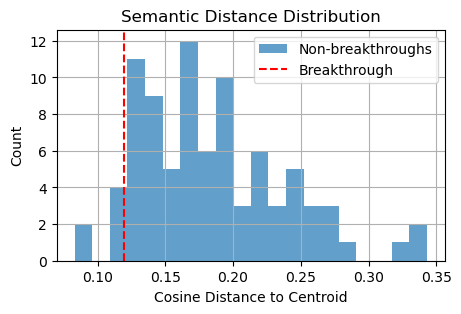

In [10]:
def evaluate(embeddings):
    # Compute centroid of all previous patent excluding breakthrough
    centroid = embeddings[1:].mean(axis=0, keepdims=True)

    # Compute cosine distances to centroid
    distances = cdist(embeddings, centroid, metric='cosine').flatten()
    bt_dist = distances[0]
    rest_dist = distances[1:]

    # Compute emperical p-value of breakthrough patent
    cdf = np.mean(rest_dist <= bt_dist)

    return bt_dist, rest_dist, cdf

bt_dist, rest_dist, cdf = evaluate(embeddings)
print(f"Breakthrough cosine distance: {bt_dist:.4f}")
print(f"Empirical cdf: {cdf:.4f}")

# Plot distribution
plt.figure(figsize=(5, 3))
plt.hist(rest_dist, bins=20, alpha=0.7, label='Non-breakthroughs')
plt.axvline(bt_dist, color='red', linestyle='--', label='Breakthrough')

plt.xlabel("Cosine Distance to Centroid")
plt.ylabel("Count")
plt.title("Semantic Distance Distribution")
plt.legend()
plt.grid(True)
plt.show()

This simple analysis shows that Google’s PageRank patent is relatively closer to the centroid than all prior patents classified under CPC code Y10S707/99935, indicating that the PageRank patent is not an outlier but instead more typical than its counterparts.

To further examine this phenomenon, I expanded the dataset to include all breakthrough patents in [Kelly et. al. online appendix Table A.1](https://www.dropbox.com/scl/fi/vg4c4smhqk23upemv9li2/Online-Appendix-kelly-et-al-2021-measuring-technological-innovation-over-the-long-run.pdf?rlkey=jpkhct67s63kj8dsbih9uw8i1&st=1bzjq5k0&dl=0).

In [ ]:
# read in breakthrough patent data

# kelly = pd.read_excel('/gpfs/scratch/sh7008/LLM_Project/kelly_patent.xlsx', sheet_name='all table')

# abstracts = []
# bt_dist_cutoffs = []

# for patent in tqdm(kelly.Patent, desc='Breakthrough patent queried'):
#     batch = similar_patent_query(patent)
#     if batch:
#         abstracts.extend(batch)
#         bt_dist_cutoffs.append(len(batch))

# with open("/gpfs/scratch/sh7008/LLM_Project/abstracts.pkl", "wb") as f:
#     pickle.dump(abstracts, f)
# with open("/gpfs/scratch/sh7008/LLM_Project/bt_dist_cutoffs.pkl", "wb") as f:
#     pickle.load(bt_dist_cutoffs, f)

In [75]:
with open("/gpfs/scratch/sh7008/LLM_Project/abstracts.pkl", "rb") as f:
    abstracts = pickle.load(f)
with open("/gpfs/scratch/sh7008/LLM_Project/bt_dist_cutoffs.pkl", "rb") as f:
    bt_dist_cutoffs = pickle.load(f)


def batched_inference(all_abstracts, batch_size=100):
    all_embeddings = []
    for i in tqdm(range(0, len(all_abstracts), batch_size), desc="Running inference"):
        batch = all_abstracts[i:i+batch_size]
        tf.keras.backend.clear_session()
        emb = inference(batch)
        all_embeddings.append(emb)
    return np.vstack(all_embeddings)

embeddings = batched_inference(abstracts)

# some breakthroughs do not have earlier counterparts or only have one, which makes paired t-test unstable
# Therefore, I conditioned on pairs that have at least 2 non-breakthrough samples
bt_list = []
rest_list = []
start = 0
for size in bt_dist_cutoffs:
    end = start + size
    if size >= 3:
        emb_slice = embeddings[start:end]
        bt_dist, rest_dist, _ = evaluate(emb_slice)
        bt_list.append(bt_dist)
        rest_list.append(rest_dist)
    else:
        pass
    start = end

print(f'{len(bt_list)} breakthrough pairs left after filtering.')
full_bt = np.array(bt_list)

# conduct paired t-test
mean_rest = np.hstack([l.mean() for l in rest_list])
result = ttest_rel(full_bt, mean_rest, alternative='two-sided')
print(f'T-Statistic: {result.statistic}')
print(f'P-value: {result.pvalue}')

# also conduct power analysis
diff = full_bt - mean_rest
cohens_d = np.mean(diff) / np.std(diff, ddof=1)
P = TTestPower()
power = P.power(effect_size=cohens_d, nobs=len(diff), alpha=0.05, alternative='two-sided')
print(f"Cohen's d: {cohens_d}")
print(f'Power: {power}')

Running inference:   0%|                                                                                          | 0/79 [00:00<?, ?it/s]

Running inference: 100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [02:51<00:00,  2.17s/it]

36 breakthrough pairs left after filtering.
T-Statistic: 4.150236824628462
P-value: 0.00020170741021158012
Cohen's d: 0.691706137438077
Power: 0.9809572240065054


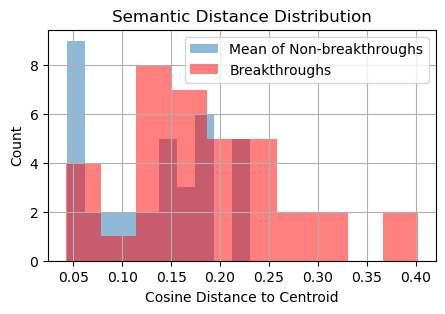

In [76]:
# plot all distances
plt.figure(figsize=(5, 3))
plt.hist(mean_rest, bins=10, alpha=0.5, label='Mean of Non-breakthroughs')
plt.hist(full_bt, bins=10, alpha=0.5, color='red', label='Breakthroughs')

plt.xlabel("Cosine Distance to Centroid")
plt.ylabel("Count")
plt.title("Semantic Distance Distribution")
plt.legend()
plt.grid(True)
plt.show()

This analysis shows that **breakthrough patents is distinguishable from CPC-matched non-breakthrough patents in their embedding-based distance to centroid**, with a p = 0.0002, a moderate-to-large effect size of 0.7, and high statistical power (0.98). However, the plot reveals substantial overlap between the two groups, indicating that this distinction may hold only within CPC classes, which raises the concern about using a model trained for CPC classification purpose to assess innovation impact.